In [2]:
import os
import numpy as np
import zipfile
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
physical_devices = tf.config.list_physical_devices("GPU")
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data preprocessing

In [5]:
path = "dataset_primary/dataset_primary/data_05S01/"
no_attack_dir = os.listdir(path + "0/")
attack_dir = os.listdir(path + "1/")

In [6]:
# Load the images and labels into memory
images = np.zeros((len(no_attack_dir) + len(attack_dir), 112, 112, 3), dtype=np.float32)
labels = np.zeros(len(no_attack_dir) + len(attack_dir), dtype=np.int32)

# load the images and labels into memory
for i, filename in enumerate(no_attack_dir):
    img = Image.open(path + "0/" + filename).convert("RGB")
    img = img.resize((112, 112), Image.BILINEAR)
    img = np.asarray(img, dtype=np.float32)
    images[i] = img
for i, filename in enumerate(attack_dir):
    img = Image.open(path + "1/" + filename).convert("RGB")
    img = img.resize((112, 112), Image.BILINEAR)
    img = np.asarray(img, dtype=np.float32)
    images[i + len(no_attack_dir)] = img
    labels[i + len(no_attack_dir)] = 1

In [7]:
labels = tf.keras.utils.to_categorical(labels, 2)
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [8]:
# Shuffle the data and split into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42
)
del images, labels

# Models

## Fully Connected NN with 64 nodes in each layer

In [10]:
FCNN64 = Sequential()
FCNN64.add(Flatten(input_shape=(112, 112, 3)))
FCNN64.add(Dense(64, activation="relu"))
FCNN64.add(Dense(64, activation="relu"))
FCNN64.add(Dense(64, activation="relu"))
FCNN64.add(Dense(2, activation='softmax'))
FCNN64.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 37632)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                2408512   
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 2)                 130       
                                                                 
Total params: 2,416,962
Trainable params: 2,416,962
Non-trainable params: 0
_________________________________________________________________


In [13]:
FCNN64.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history_FCNN64 = FCNN64.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=80,
    validation_data=(X_test, y_test),
)

Epoch 1/30
225/225 [==============================] - 4s 11ms/step - loss: 53.4805 - accuracy: 0.7505 - val_loss: 7.1332 - val_accuracy: 0.7760
Epoch 2/30
225/225 [==============================] - 1s 6ms/step - loss: 3.1078 - accuracy: 0.7837 - val_loss: 0.9365 - val_accuracy: 0.7326
Epoch 3/30
225/225 [==============================] - 1s 6ms/step - loss: 9.7951 - accuracy: 0.7647 - val_loss: 4.6480 - val_accuracy: 0.8012
Epoch 4/30
225/225 [==============================] - 1s 6ms/step - loss: 2.8745 - accuracy: 0.7894 - val_loss: 0.7868 - val_accuracy: 0.7929
Epoch 5/30
225/225 [==============================] - 1s 6ms/step - loss: 0.7897 - accuracy: 0.7986 - val_loss: 0.7910 - val_accuracy: 0.8103
Epoch 6/30
225/225 [==============================] - 1s 6ms/step - loss: 0.6014 - accuracy: 0.8098 - val_loss: 0.6050 - val_accuracy: 0.7802
Epoch 7/30
225/225 [==============================] - 1s 7ms/step - loss: 0.7363 - accuracy: 0.8001 - val_loss: 0.8235 - val_accuracy: 0.7858
Epoc

## CNN with 64 nodes in each layer

In [14]:
CNN64 = Sequential()
CNN64.add(Conv2D(64, (3, 3), activation="relu", input_shape=(112, 112, 3)))
CNN64.add(MaxPooling2D((2, 2)))
CNN64.add(Conv2D(64, (3, 3), activation="relu"))
CNN64.add(MaxPooling2D((2, 2)))
CNN64.add(Conv2D(64, (3, 3), activation='relu'))
CNN64.add(MaxPooling2D((2, 2)))
CNN64.add(Flatten())
CNN64.add(Dense(64, activation='relu'))
CNN64.add(Dense(2, activation='softmax'))
CNN64.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)      

In [15]:
CNN64.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history_CNN64 = CNN64.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=80,
    validation_data=(X_test, y_test),
)

Epoch 1/30
225/225 [==============================] - 12s 22ms/step - loss: 5.1184 - accuracy: 0.7979 - val_loss: 0.4101 - val_accuracy: 0.8143
Epoch 2/30
225/225 [==============================] - 3s 15ms/step - loss: 0.3400 - accuracy: 0.8377 - val_loss: 0.3374 - val_accuracy: 0.8326
Epoch 3/30
225/225 [==============================] - 3s 16ms/step - loss: 0.3188 - accuracy: 0.8446 - val_loss: 0.3415 - val_accuracy: 0.8239
Epoch 4/30
225/225 [==============================] - 3s 16ms/step - loss: 0.3102 - accuracy: 0.8500 - val_loss: 0.3333 - val_accuracy: 0.8332
Epoch 5/30
225/225 [==============================] - 3s 15ms/step - loss: 0.2998 - accuracy: 0.8519 - val_loss: 0.3361 - val_accuracy: 0.8317
Epoch 6/30
225/225 [==============================] - 4s 16ms/step - loss: 0.2984 - accuracy: 0.8545 - val_loss: 0.3267 - val_accuracy: 0.8424
Epoch 7/30
225/225 [==============================] - 4s 16ms/step - loss: 0.2916 - accuracy: 0.8551 - val_loss: 0.3248 - val_accuracy: 0.843

# Comparison

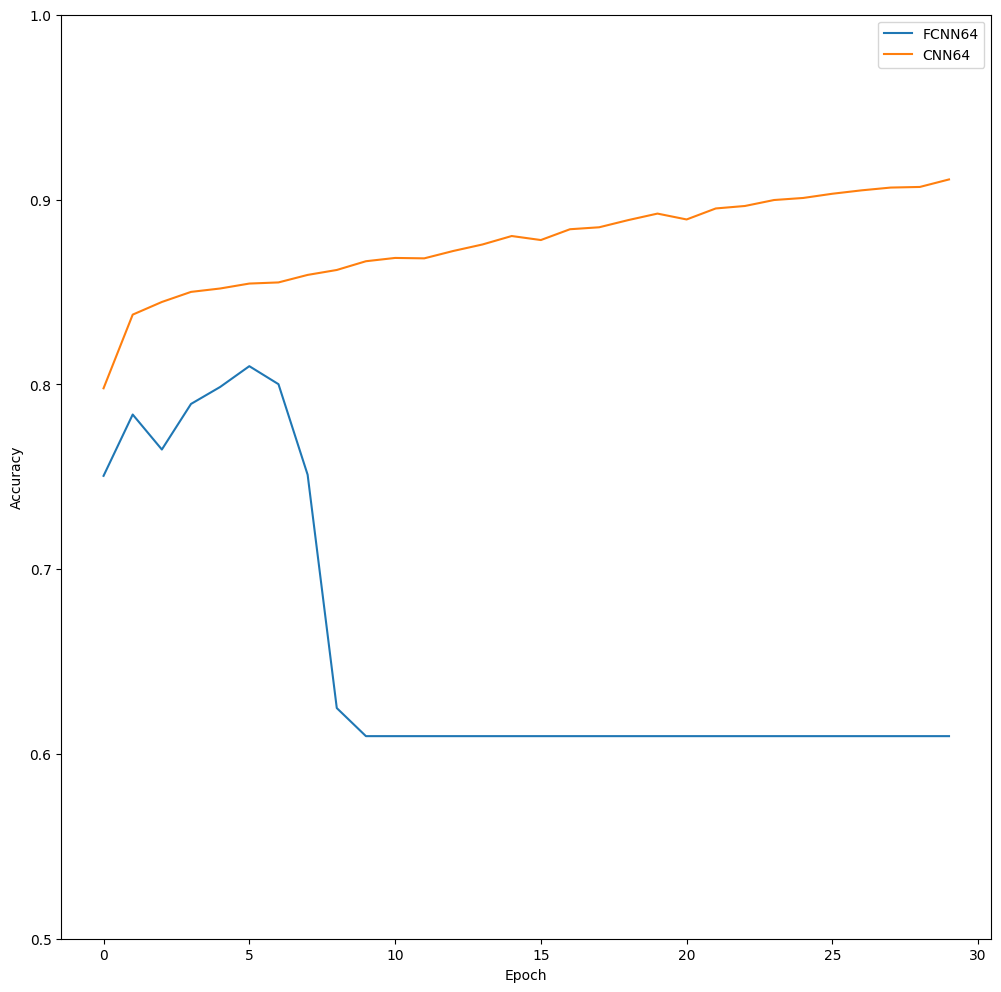

In [21]:
plt.figure(figsize=((12, 12)))

for history, name in zip([history_FCNN64, history_CNN64], ['FCNN64', 'CNN64']):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(acc))
    plt.plot(epochs, acc, label=name)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim((.50, 1.00))
plt.legend()

    

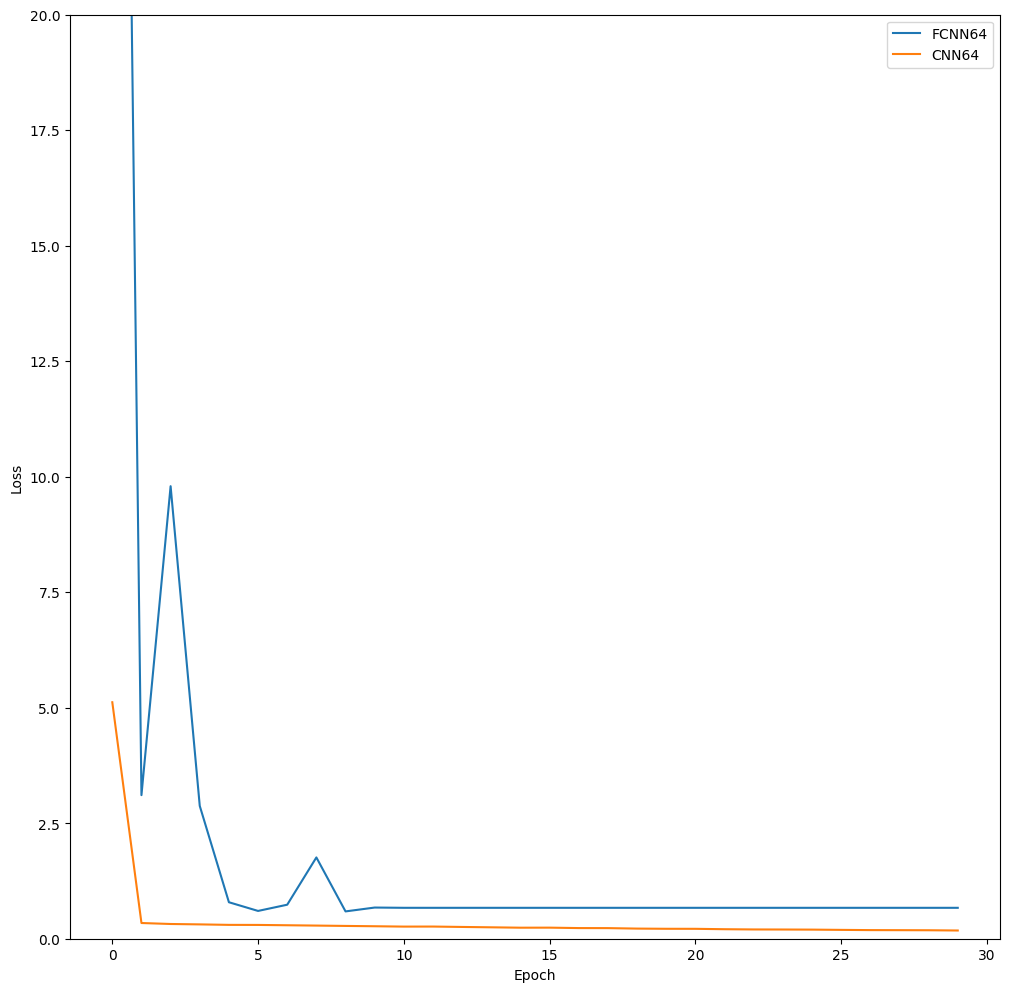

In [24]:
plt.figure(figsize=((12, 12)))

for history, name in zip([history_FCNN64, history_CNN64], ['FCNN64', 'CNN64']):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(acc))
    plt.plot(epochs, loss, label=name)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim((0, 20))
plt.legend()